In [2]:
import sys, site, pathlib

print("sys.prefix:", sys.prefix)
print("sys.base_prefix:", sys.base_prefix)
print("in_venv:", sys.prefix != sys.base_prefix)

print("site-packages:")
for p in site.getsitepackages():
    print("  ", p)
import numpy as np
import pandas as pd
print("numpy:", np.__version__, "->", pathlib.Path(np.__file__).parents[1])
print("pandas:", pd.__version__, "->", pathlib.Path(pd.__file__).parents[1])


sys.prefix: /home/anabel/repositories/FoDS_Practicals/.venv
sys.base_prefix: /usr
in_venv: True
site-packages:
   /home/anabel/repositories/FoDS_Practicals/.venv/lib/python3.10/site-packages
   /home/anabel/repositories/FoDS_Practicals/.venv/local/lib/python3.10/dist-packages
   /home/anabel/repositories/FoDS_Practicals/.venv/lib/python3/dist-packages
   /home/anabel/repositories/FoDS_Practicals/.venv/lib/python3.10/dist-packages
numpy: 2.2.6 -> /home/anabel/repositories/FoDS_Practicals/.venv/lib/python3.10/site-packages
pandas: 2.3.3 -> /home/anabel/repositories/FoDS_Practicals/.venv/lib/python3.10/site-packages


In [3]:
import ast

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import textwrap

# Loading Data

In [4]:
df = pd.read_pickle("../data/df_train.pkl")

df_train, df_val = train_test_split(df, test_size= 0.2, random_state=83)

In [5]:
X_train = df_train.business_description_embedding.apply(ast.literal_eval).tolist()
X_train = np.array(X_train)

X_val = df_val.business_description_embedding.apply(ast.literal_eval).tolist()
X_val = np.array(X_val)

print(X_train.shape)
print(X_val.shape)

(25364, 768)
(6342, 768)


In [6]:
df_train.head(3)

,id,industry,business_description_embedding
18663,20377,Materials,"[-0.025557408,0.0636078,-0.01350581,-0.0180223..."
8808,9581,Consumer Discretionary Distribution & Retail,"[0.006044266,-0.028527925,-0.007514423,0.05474..."
22327,24441,Materials,"[-0.025557408,0.0636078,-0.01350581,-0.0180223..."


# Transforming Data (Label Encoding)

### Tasks:
- Use the scikit-learn label encoder to encode the industry names
- Check if all classes contained in the validation set are also in the training set

#

In [7]:
label_encoder = LabelEncoder().fit(y=df_train["industry"].values.ravel())
print(label_encoder.classes_)


['Automobiles & Components' 'Banks' 'Capital Goods'
 'Commercial & Professional Services'
 'Consumer Discretionary Distribution & Retail'
 'Consumer Durables & Apparel' 'Consumer Services'
 'Consumer Staples Distribution & Retail' 'Energy'
 'Equity Real Estate Investment Trusts (REITs)' 'Financial Services'
 'Food, Beverage & Tobacco' 'Health Care Equipment & Services'
 'Household & Personal Products' 'Insurance' 'Materials'
 'Media & Entertainment' 'Pharmaceuticals, Biotechnology & Life Sciences'
 'Real Estate Management & Development'
 'Semiconductors & Semiconductor Equipment' 'Software & Services'
 'Technology Hardware & Equipment' 'Telecommunication Services'
 'Transportation' 'Utilities']


In [8]:
train_classes = set(df_train['industry'].sort_values())
print("Training classes:", train_classes)
val_classes = set(df_val['industry'].sort_values())
print("Validation classes:", val_classes)
if val_classes == train_classes:
    print("validation and training set contain the exact same classes")
elif val_classes.issubset(train_classes):
    print("Validation set is a subset of training set, but training set has additional classes")
else: print("Attention: validation set contains classes that are not in the training set")

Training classes: {'Banks', 'Energy', 'Telecommunication Services', 'Media & Entertainment', 'Food, Beverage & Tobacco', 'Financial Services', 'Real Estate Management & Development', 'Equity Real Estate Investment Trusts (REITs)', 'Consumer Discretionary Distribution & Retail', 'Semiconductors & Semiconductor Equipment', 'Capital Goods', 'Consumer Staples Distribution & Retail', 'Software & Services', 'Pharmaceuticals, Biotechnology & Life Sciences', 'Household & Personal Products', 'Health Care Equipment & Services', 'Transportation', 'Commercial & Professional Services', 'Consumer Durables & Apparel', 'Utilities', 'Insurance', 'Consumer Services', 'Automobiles & Components', 'Technology Hardware & Equipment', 'Materials'}
Validation classes: {'Banks', 'Energy', 'Telecommunication Services', 'Media & Entertainment', 'Food, Beverage & Tobacco', 'Financial Services', 'Real Estate Management & Development', 'Equity Real Estate Investment Trusts (REITs)', 'Consumer Discretionary Distribut

In [137]:
y_train = label_encoder.transform(df_train['industry'])
y_val = label_encoder.transform(df_val['industry']) 

y_val

array([22, 10, 15, ...,  9, 20, 15], shape=(6342,))

# Visualize the data

### Tasks:
- Are certain classes over- or under represented? Either produce a table or a plot to show this.
- Inspect whether there is signal in the business description embeddings:
    - Perform a PCA to project data into 2 dimensions
    - Plot projected data in Scatterplot and color based on classes
    - Provide a description of what you see and judge whether there is signal in the data that allows industry classification

Important: Ensure that your plots have proper axis descriptions and titles. Style the plots so that differences in class distributions are visible (e.g. scatter size, transparency, color, etc.)

### Class distribution

/tmp/ipykernel_1331/862795687.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


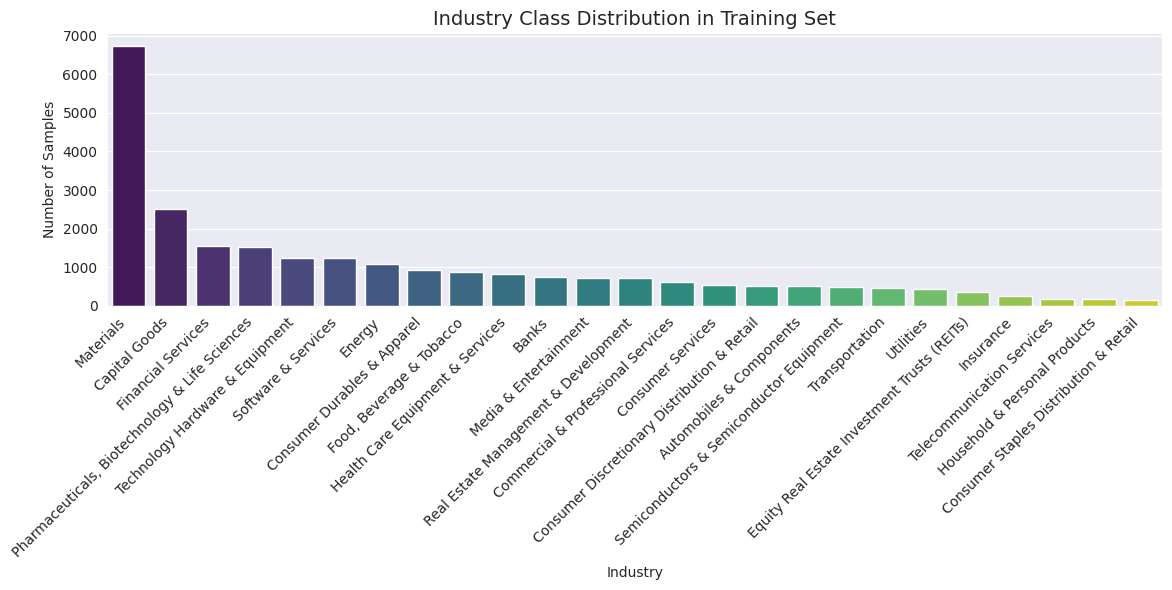

In [10]:
plt.figure(figsize=(12,6))
sns.barplot(
    x=df_train['industry'].value_counts().index,
    y=df_train['industry'].value_counts().values,
    palette='viridis'
)
plt.title("Industry Class Distribution in Training Set", fontsize=14)
plt.xlabel("Industry")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [11]:
print("Class Distribution with Percentages:\n")
print(
    df_train['industry']
    .value_counts(normalize=False)
    .to_frame(name='count')
    .assign(percentage=lambda df: (df['count'] / df['count'].sum() * 100).round(2))
    .reset_index()
    .rename(columns={'index': 'industry'})
)

Class Distribution with Percentages:

                                          industry  count  percentage
0                                        Materials   6727       26.52
1                                    Capital Goods   2515        9.92
2                               Financial Services   1543        6.08
3   Pharmaceuticals, Biotechnology & Life Sciences   1525        6.01
4                  Technology Hardware & Equipment   1244        4.90
5                              Software & Services   1237        4.88
6                                           Energy   1083        4.27
7                      Consumer Durables & Apparel    925        3.65
8                         Food, Beverage & Tobacco    873        3.44
9                 Health Care Equipment & Services    813        3.21
10                                           Banks    756        2.98
11                           Media & Entertainment    716        2.82
12            Real Estate Management & Development  

## <span style='color: green;'>Our Findings</span>
The classes are not well balanced. As there are 25 industries, if the industies would be proportionally present in the data, we would expect all of them to make up 1/25 = 4 percent of the population. Instead, the "Materials" class is highly overrepresented, the "Capital Goods", "Pharmaceuticals, Biotechnology & Life Sciences" and "Financial Services" classes are overrepresented, and the classes "Technology Hardware & Equipment", "Software & Services" and "Energy" are slighlty overrepresented. The other classes are underrepresented. Highly underrepresented classes are "Insureance", "Household & Personal Products", "Telecommunication Services" and "Consumer Staples Distribution & Retail".


### PCA - Dimensionality reduction and visualization

In [12]:
X_train

array([[-0.02555741,  0.0636078 , -0.01350581, ..., -0.00419293,
        -0.04597831,  0.01839585],
       [ 0.00604427, -0.02852792, -0.00751442, ..., -0.02317977,
        -0.06096176, -0.04888349],
       [-0.02555741,  0.0636078 , -0.01350581, ..., -0.00419293,
        -0.04597831,  0.01839585],
       ...,
       [ 0.08103544, -0.02023666, -0.03422775, ...,  0.0210675 ,
        -0.03842652,  0.00306445],
       [ 0.02336214,  0.02999316, -0.01335469, ..., -0.03468461,
        -0.04350951, -0.00251376],
       [ 0.03245761, -0.01945133, -0.03252771, ..., -0.0193117 ,
        -0.04382166, -0.03561667]], shape=(25364, 768))

In [13]:
pca = PCA(n_components=2).fit(X_train)
X_train_proj = pca.transform(X_train)

X_train_proj

array([[-0.8434818 ,  0.00319437],
       [ 0.18059012, -0.20546771],
       [-0.8434818 ,  0.00319437],
       ...,
       [ 0.10245782, -0.05083063],
       [ 0.22378296,  0.05593288],
       [ 0.18444744,  0.02146143]], shape=(25364, 2))

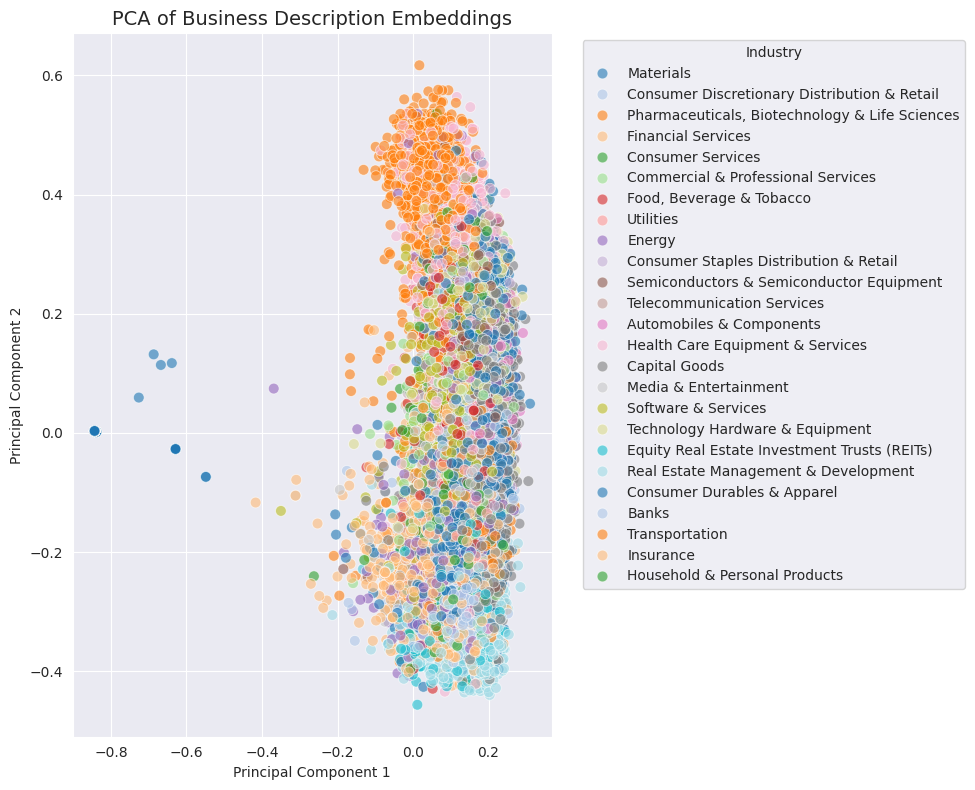

In [14]:
pca_df = pd.DataFrame({
    'PC1': X_train_proj[:, 0],
    'PC2': X_train_proj[:, 1],
    'industry': df_train['industry'].values
})

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='industry',
    palette='tab20',
    alpha=0.6,
    s=60,
    edgecolor='w' 
)
plt.title("PCA of Business Description Embeddings", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Industry", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [15]:
pca.explained_variance_ratio_

array([0.19182905, 0.06110768])

In [16]:
print(
    f"The first component explains {pca.explained_variance_ratio_[0]*100:.2f}% "
    f"of the variance; the second explains {pca.explained_variance_ratio_[1]*100:.2f}%."
)
print(f"The train set has the following rows and columns/dimensions: {X_train.shape}")
print(f"The train set has {df_train['industry'].nunique()} unique industry classes.")

The first component explains 19.18% of the variance; the second explains 6.11%.
The train set has the following rows and columns/dimensions: (25364, 768)
The train set has 25 unique industry classes.


## <span style='color: green;'>Our Findings</span>
It is difficult to say whether the signal allows for good classification, because the way the 768 dimensions got reduced to 2. However, it seems there is some clustering, so we assume some okay-ish/good classification is possible.



# Fitting and comparing Classifier Models

### Tasks:
- Split the data into train and validation data <span style='color: green;'> This was done already at the beginning of the file, where it says "train_test_split"</span>
- Encode the industry labels using LabelEncoder (scikit-learn) <span style='color: green;'> This was done already at the beginning of the file, wehre it says "label_encoder"</span>
- Fit a LogisticRegression and a kNN-classifier 
- Compare the model performance of both models:
    - Compute Accuracy and F1 score
        - Interpret the scores: Explain how they are computed and judge if your model performs well
        - Analyze the classification errors
            - Do the errors correlate with how well classes are represented? 
            - Which industries does the model identify well and which seem to be similar? 
    - Plot a confusion matrix for both models (combine scikit-learn confusion matrix and seaborn heatmap plot) 
    - Do both models misclassify the same examples?

Import: Use proper axis labels for the plots! 

In [17]:
log_reg = LogisticRegression(C=5, class_weight=None, max_iter=1000, random_state=83)
#TODO: Add rational for the parameters C=5, class_weight=None, max_iter=1000
log_reg.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,5
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,83
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [18]:
knn = KNeighborsClassifier(n_neighbors=15, weights='distance', metric='cosine')
#TODO: Add rational for the parameters n_neighbors=15, weights='distance', metric='cosine'
knn.fit(X_train, y_train)

,n_neighbors,15
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'cosine'
,metric_params,None
,n_jobs,None


In [19]:
y_pred_log = log_reg.predict(X_val)
y_pred_knn = knn.predict(X_val)

log_accuracy = accuracy_score(y_val, y_pred_log)
log_f1 = f1_score(y_val, y_pred_log, average='weighted')

knn_accuracy = accuracy_score(y_val, y_pred_knn)
knn_f1 = f1_score(y_val, y_pred_knn, average='weighted')

print(f"\nLogistic Regression:")
print(f"  Accuracy: {log_accuracy:.4f}")
print(f"  F1-score: {log_f1:.4f}")

print(f"\nk-Nearest Neighbors:")
print(f"  Accuracy: {knn_accuracy:.4f}")
print(f"  F1-score: {knn_f1:.4f}")

if log_accuracy == knn_accuracy:
    print(f"\n Both models perform the same with both Logistic Regression and Nearest Neighbors having {(knn_accuracy):.4f} accuracy points")
elif log_accuracy > knn_accuracy:
    print(f"\n Logistic Regression performs better by {(log_accuracy - knn_accuracy):.4f} accuracy points")
else:
    print(f"\n k-NN performs better by {(knn_accuracy - log_accuracy):.4f} accuracy points")


Logistic Regression:
  Accuracy: 0.7690
  F1-score: 0.7643

k-Nearest Neighbors:
  Accuracy: 0.7690
  F1-score: 0.7623

 Both models perform the same with both Logistic Regression and Nearest Neighbors having 0.7690 accuracy points


## <span style='color: green;'>Model Performance Interpretation</span>

### What do these metrics mean?

**Accuracy**: 
- Measures the percentage of correct predictions out of all predictions
- Formula: (True Positives + True Negatives) / Total Predictions
- Easy to interpret but can be misleading with imbalanced classes

**F1-Score (Weighted)**:
- Harmonic mean of precision and recall, weighted by class support
- Formula: 2 × (Precision × Recall) / (Precision + Recall)
- Better metric for imbalanced datasets as it considers not only true positives but in relation to false positives and false negatives

### Performance Assessment:

The performance is accebtable, especially given that the classes are imbalanced. A good inidcator is, that accuracy and f1 score are very similar, so the model does not simplify classifications to the "Materials" class, which is strongly overrepresented in the train set.

In [20]:
def compute_log_conf_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_for_colors = cm.astype(float)
    cm_for_colors[cm_for_colors == 0] = 1e-5  # Avoid log(0)
    annot = cm.astype(str)
    return cm, cm_for_colors, annot

def wrap_labels(labels, width=15):
    return [textwrap.fill(label, width=width) for label in labels]

def plot_single_conf_matrix(cm_colors, annot, labels, title, cmap='Blues', vmax=None):
    plt.figure(figsize=(20, 20))
    sns.heatmap(
        cm_colors,
        annot=annot,
        fmt='',
        cmap=cmap,
        norm=LogNorm(vmin=1, vmax=vmax if vmax else cm_colors.max()),
        xticklabels=labels,
        yticklabels=labels,
        cbar_kws={'label': 'Log-scaled count'}
    )
    plt.title(title, fontsize=16)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(fontsize=9)
    plt.tight_layout()
    plt.show()


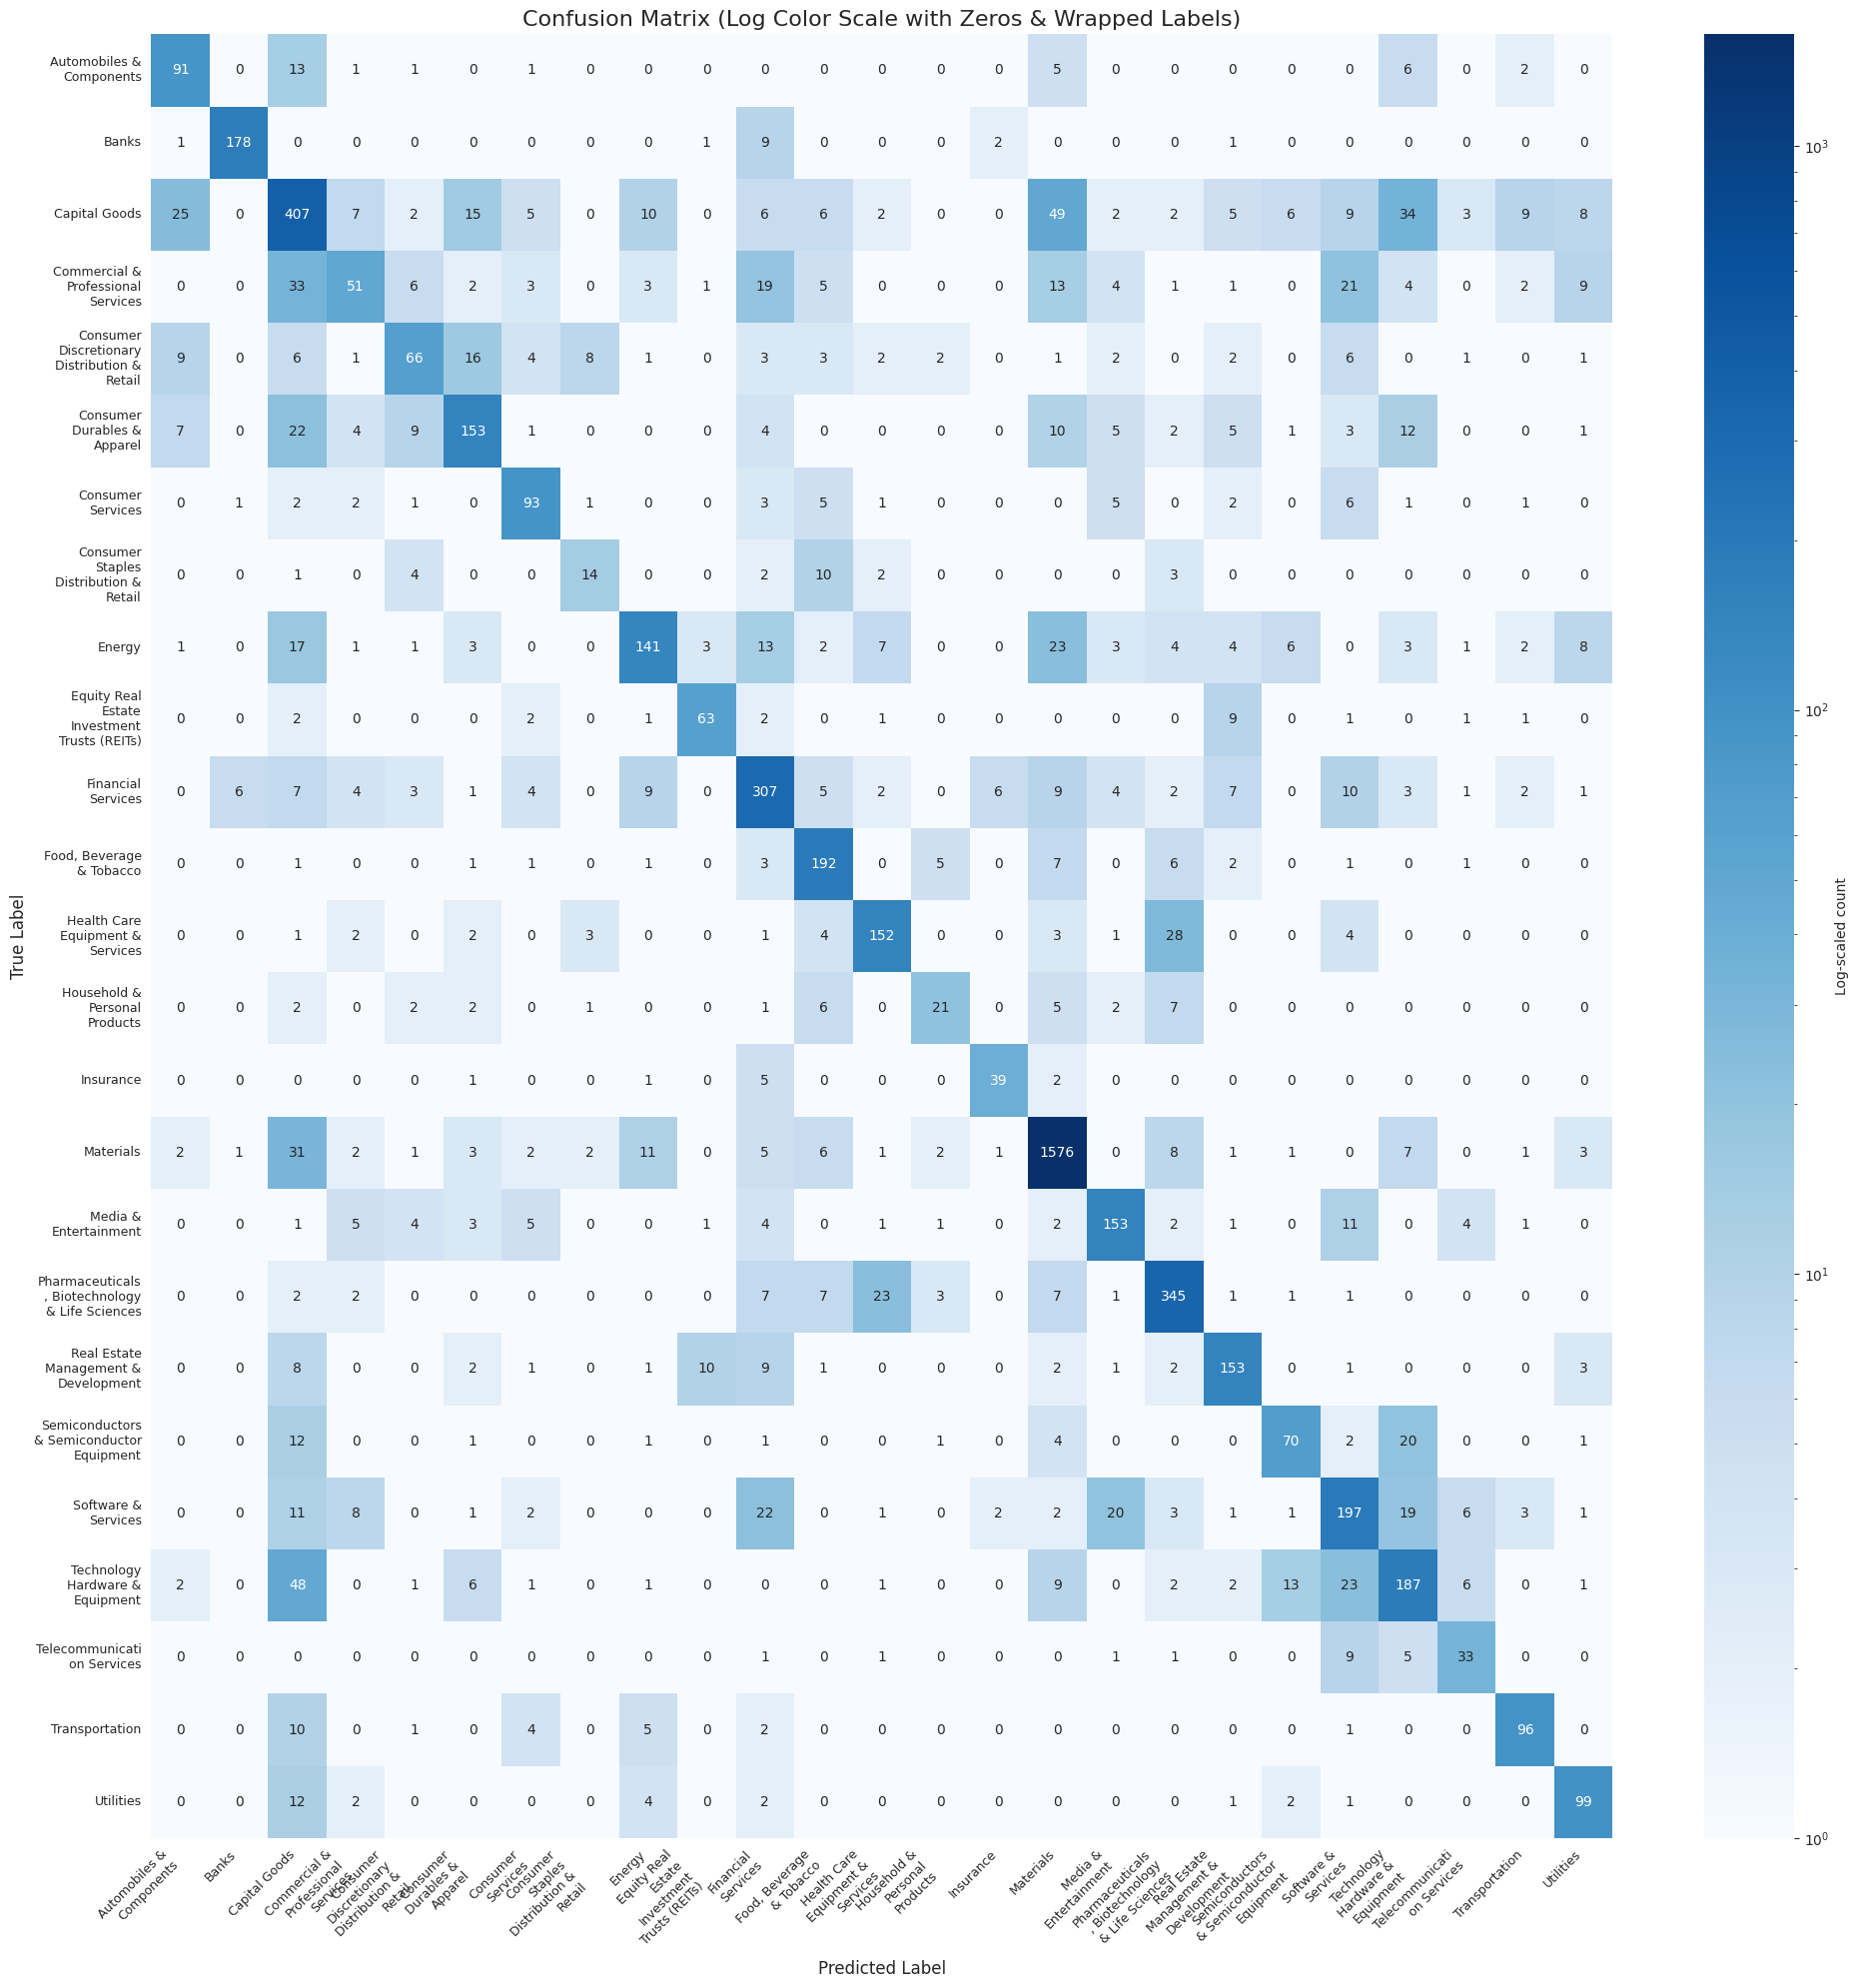

In [21]:
label_indices = np.arange(len(label_encoder.classes_))
wrapped_labels = wrap_labels(label_encoder.classes_)

cm, cm_for_colors, annot = compute_log_conf_matrix(y_val, y_pred_log, label_indices)

plot_single_conf_matrix(
    cm_for_colors,
    annot,
    wrapped_labels,
    title="Confusion Matrix (Log Color Scale with Zeros & Wrapped Labels)",
    cmap='Blues',
    vmax=cm.max()
)

## <span style='color: green;'>Classification Analysis</span>

It seems that the overall classification worked well, indicated by the strong diagonal. However, there is also visble, that several missclassifications happened. Interestingly, these often happened in classes which are also semantically similar, e.g. "software & services" and "technology, hardware & equipment", or other example "capital goods" and "materials". This indicates, that this error might be due to the similarity and semantical overlap of the classes. "Banks", "Telecommunications services" and "Transportation" are remarkably well classified. We assume, becasue they have a strong pattern. E.g. Banks deal with a lot of money, are almost always profitable and hold few physical assests, while transportation holds mainly physical assests, and due to the competitive market in that area, we assume most of what is earned is also spend directly. Telecommunication we guess have good margins as well in financial terms, or a somehow unique pattern in the fincial data, that was well learned.

Interestingly, classes with many examples in the set were not necessarily better classified than classes with fewer examples. Presumably, because it is more about the pattern of the data, and if it is unique, or if classes, as explained above, have overlap in these data patterns, most likely also due to semantical overlap of the classes, meaning the businesses overlap somehow, have similar markets, hence also similar earnings, margins etc. 


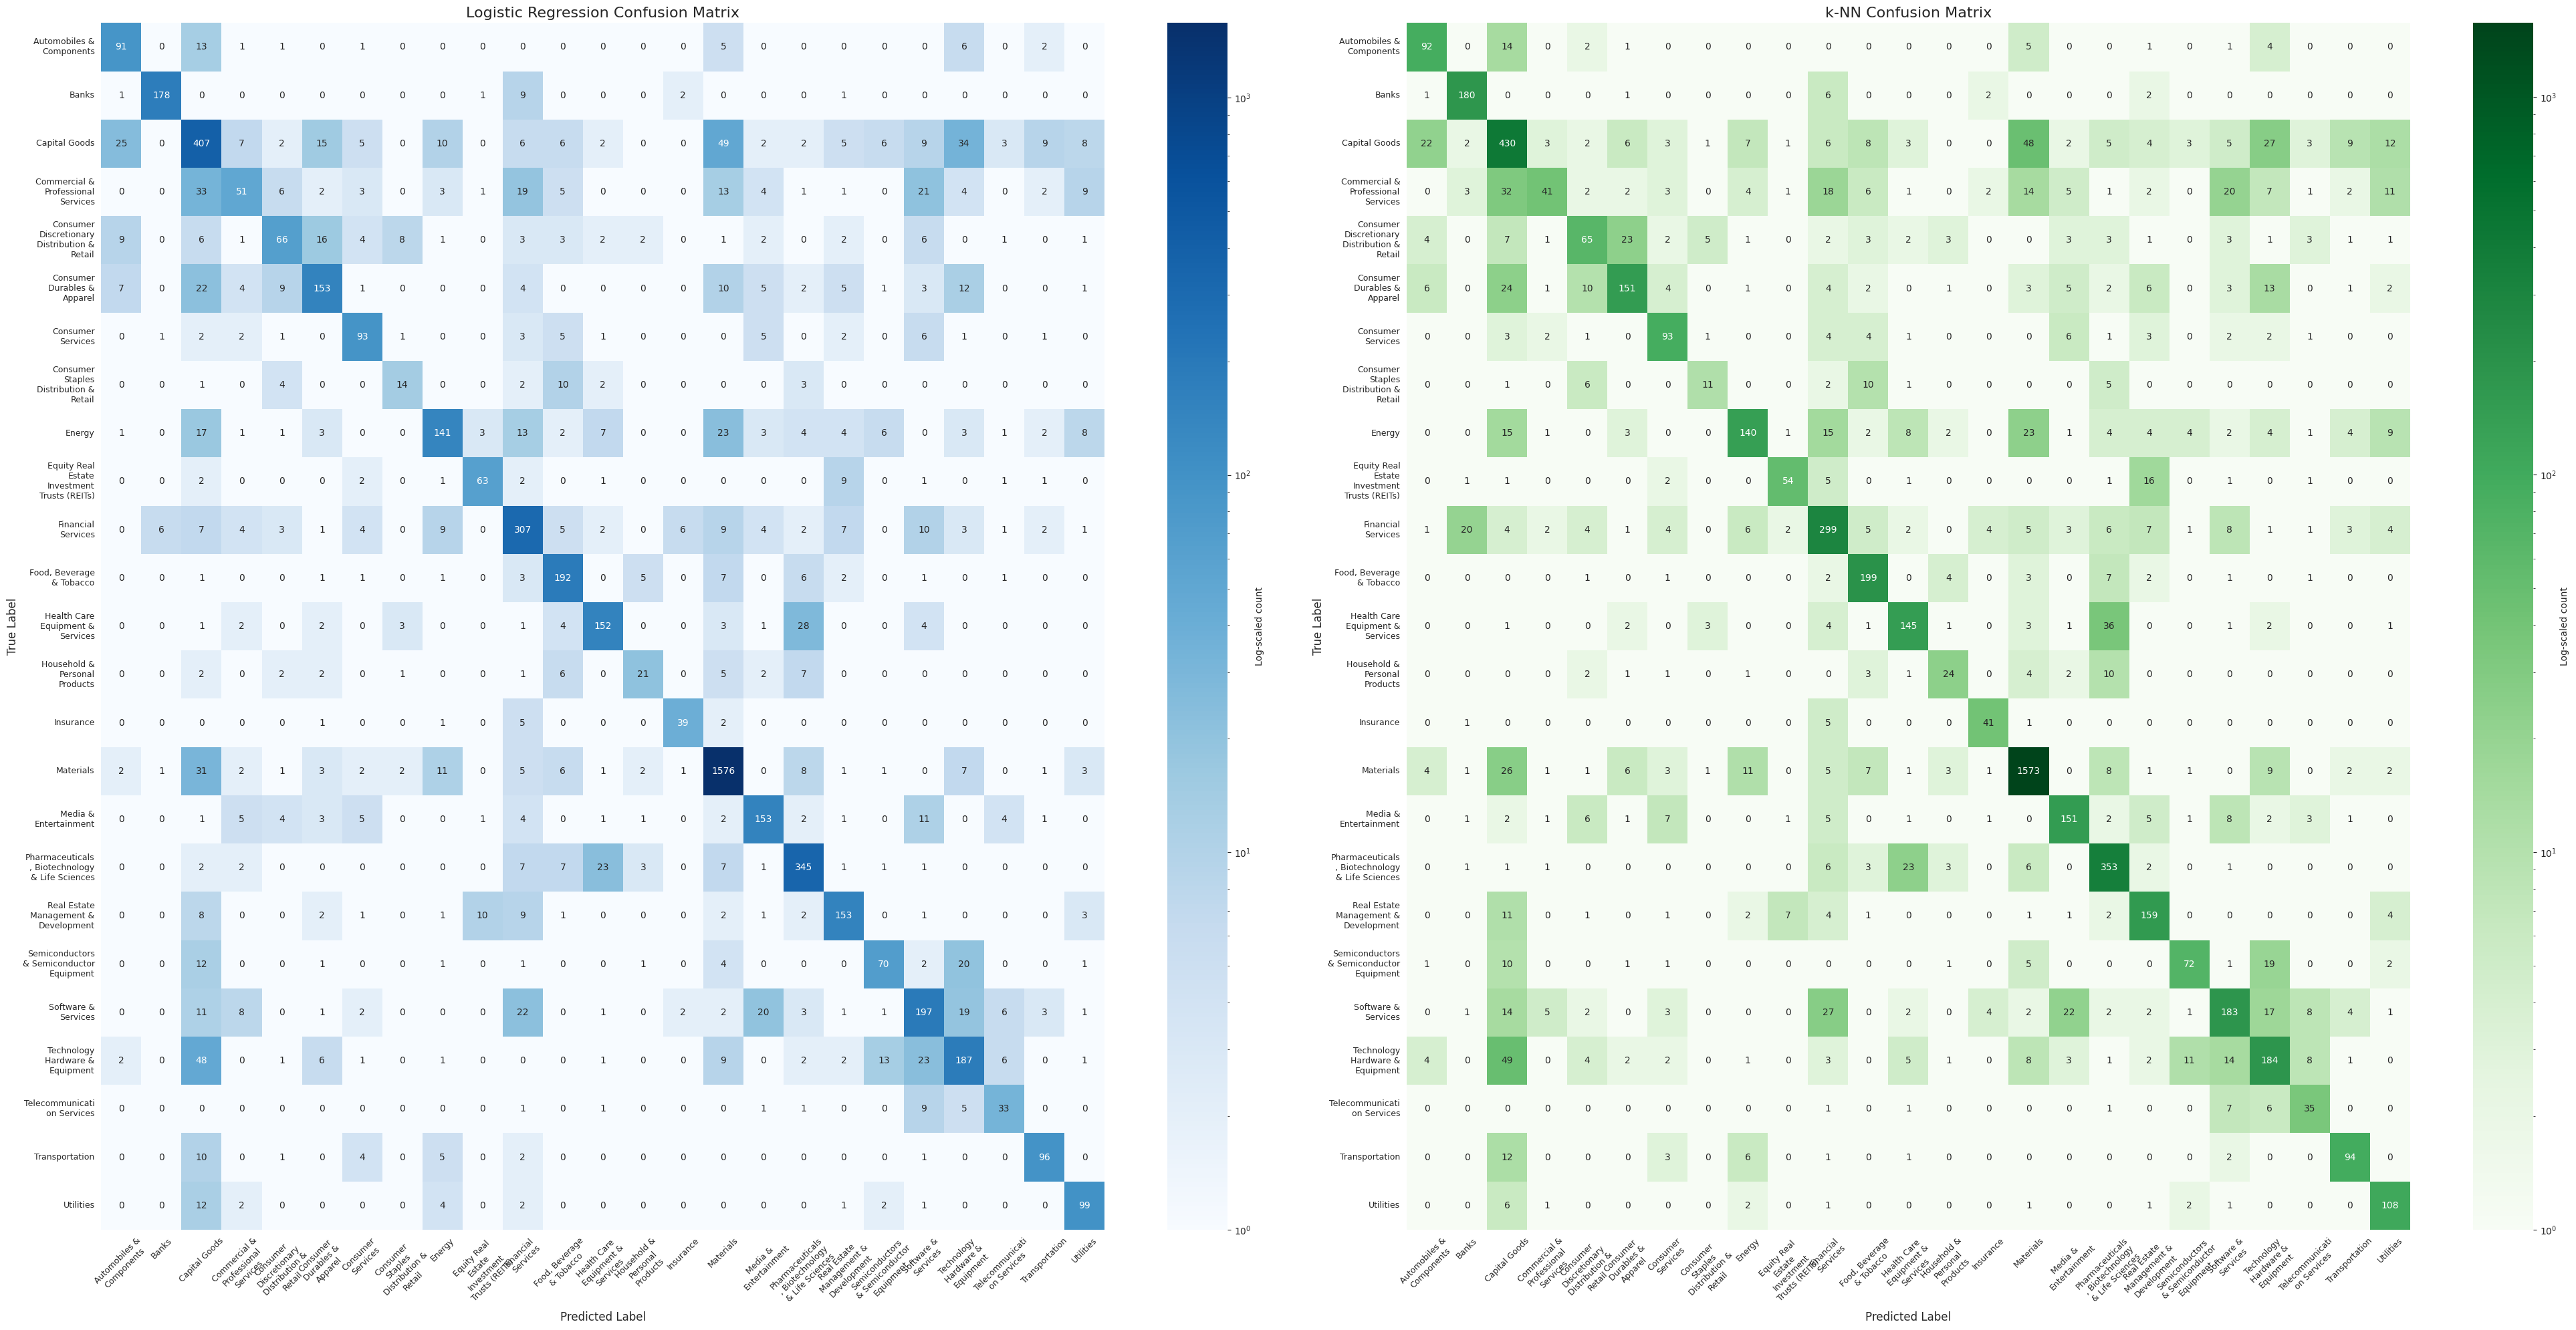

In [22]:
label_indices = np.arange(len(label_encoder.classes_))
wrapped_labels = wrap_labels(label_encoder.classes_)

cm_log, cm_log_colors, annot_log = compute_log_conf_matrix(y_val, y_pred_log, label_indices)
cm_knn, cm_knn_colors, annot_knn = compute_log_conf_matrix(y_val, y_pred_knn, label_indices)

fig, axes = plt.subplots(1, 2, figsize=(40, 20))

def plot_to_axis(ax, cm_colors, annot, labels, title, cmap, vmax):
    sns.heatmap(
        cm_colors,
        annot=annot,
        fmt='',
        cmap=cmap,
        norm=LogNorm(vmin=1, vmax=vmax),
        xticklabels=labels,
        yticklabels=labels,
        cbar_kws={'label': 'Log-scaled count'},
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Predicted Label", fontsize=12)
    ax.set_ylabel("True Label", fontsize=12)
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    ax.tick_params(axis='y', labelsize=9)

plot_to_axis(
    axes[0],
    cm_log_colors,
    annot_log,
    wrapped_labels,
    title="Logistic Regression Confusion Matrix",
    cmap='Blues',
    vmax=cm_log.max()
)

plot_to_axis(
    axes[1],
    cm_knn_colors,
    annot_knn,
    wrapped_labels,
    title="k-NN Confusion Matrix",
    cmap='Greens',
    vmax=cm_knn.max()
)

plt.tight_layout()
plt.show()


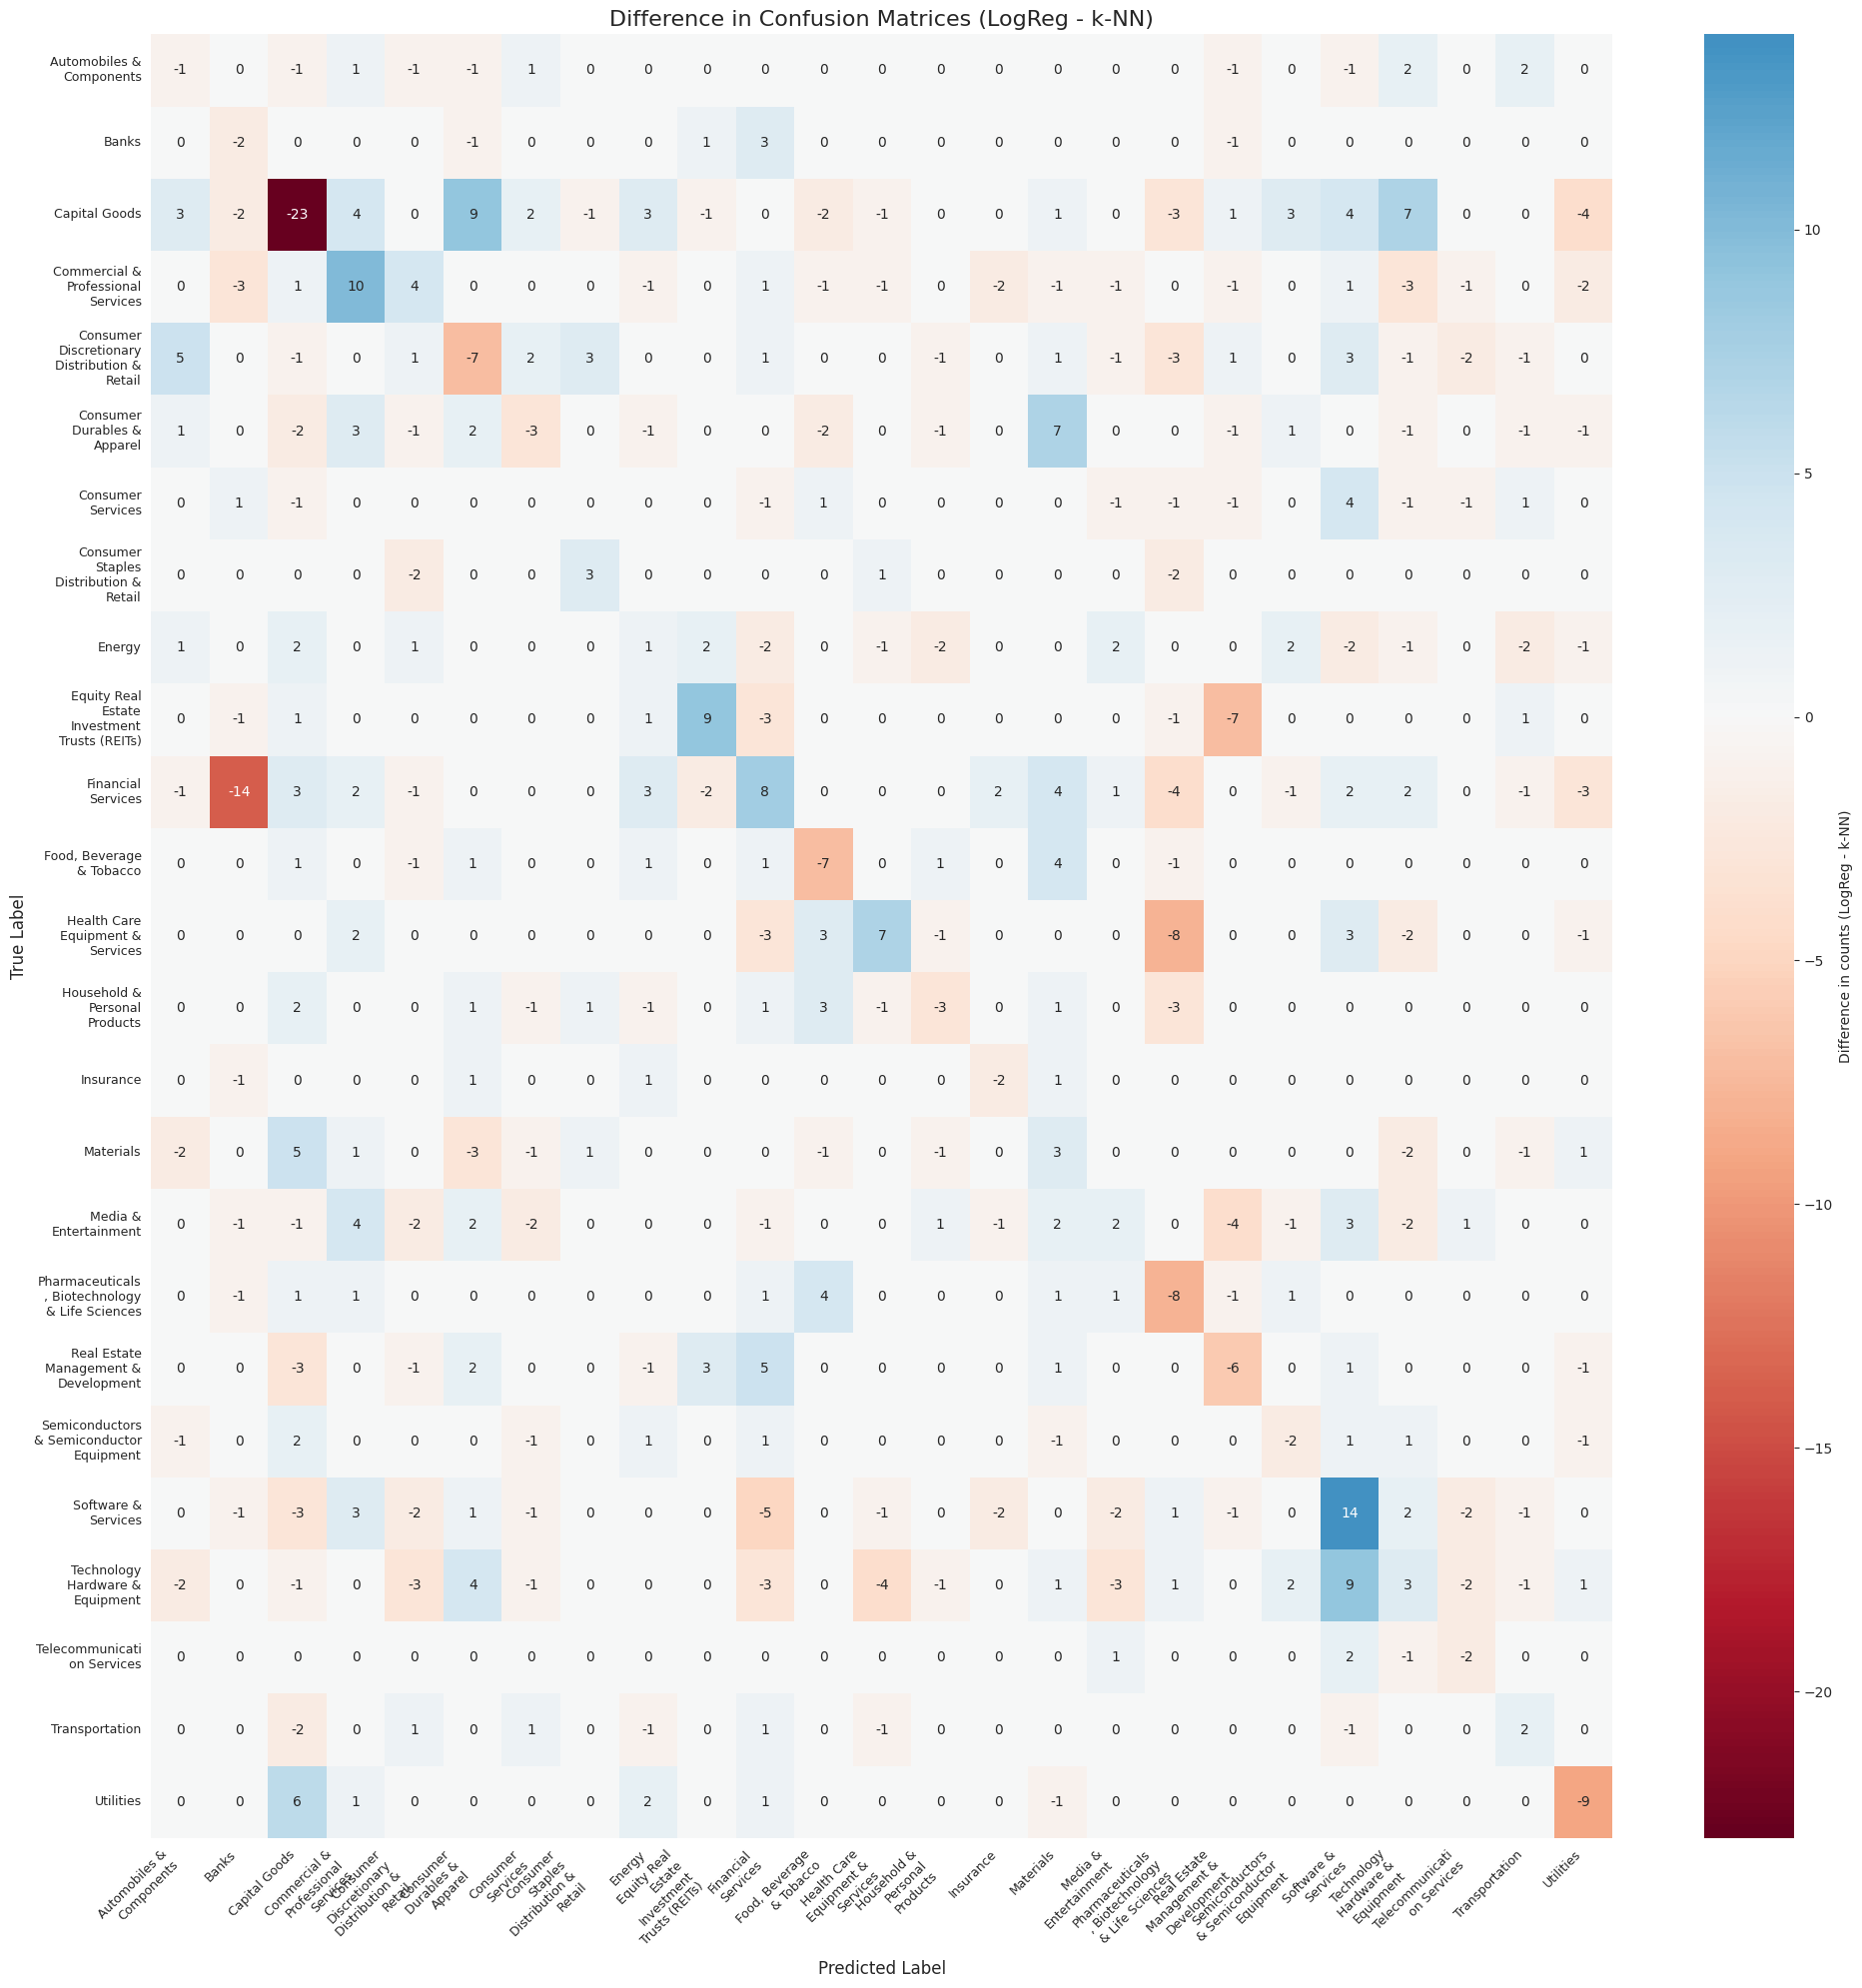

In [23]:
diff_cm = cm_log - cm_knn

annot_diff = diff_cm.astype(str)

plt.figure(figsize=(20, 20))
sns.heatmap(
    diff_cm,
    annot=annot_diff,
    fmt='',
    cmap='RdBu',         # Diverging color map
    center=0,            # 0 difference is white
    xticklabels=wrapped_labels,
    yticklabels=wrapped_labels,
    cbar_kws={'label': 'Difference in counts (LogReg - k-NN)'}
)
plt.title("Difference in Confusion Matrices (LogReg - k-NN)", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()


## <span style='color: green;'>KNN LogReg comparison</span>

As is visible in when showing the differences of the two matrices, the models make not identical but very similar classifications, also regarding the mistakes. Most of the diffeerences is in the range of 0 to +/-3, where 0, so identical classification numbers, is by far the most common 

# Optional: Confidence Weighted Prediction

## Deliverables:

- Provide a notebook with the implementation and training of a industry classifier model
- The model shall output the industry classification and its confidence as a tuple of vectors $(\hat{y}_{pred}, \hat{y}_{confidence})$
- The confidence score must be between 0 and 1, $\hat{y}_{confidence} [i] \in [0,1]$
- Your model will be evaluated on a private test set
- The designing the confidence score is your task. You may use p-values, a voting mechanism of multiple models, or other techniques
- Another option is to add more features, e.g. financial data, to X

In [24]:
def confidence_weighted_f1(y_true, y_pred, confidence):
    # Weight all predictions, not just positives
    weighted_tp = np.sum(confidence * (y_pred == 1) * (y_true == 1))
    weighted_fp = np.sum(confidence * (y_pred == 1) * (y_true == 0))
    weighted_fn = np.sum(confidence * (y_pred == 0) * (y_true == 1))
    
    precision = weighted_tp / (weighted_tp + weighted_fp) if (weighted_tp + weighted_fp) > 0 else 0
    recall = weighted_tp / (weighted_tp + weighted_fn) if (weighted_tp + weighted_fn) > 0 else 0
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1

### handle outliers and missing data incl. Embedding-based predictions from machine learning models
insparation / I watched the following youtube videos when googling how to handle outliers and missing data:
- https://www.youtube.com/watch?v=kfO5L1snlpE&t=185s
- https://www.youtube.com/watch?v=CdgvW-Vf_U8
- https://www.youtube.com/watch?v=3UKHOyznSdQ
- https://www.youtube.com/watch?v=rsyrZnZ8J2o
Embedding-based predictions from machine learning models is already covered by using the text embeddings from the mandatory part

In [25]:
df

id                            industry  \
38532  42576                               Banks   
19838  21752                           Materials   
904      804  Commercial & Professional Services   
28806  31603                           Insurance   
10472  11333                       Capital Goods   
...      ...                                 ...   
6267    6403                       Capital Goods   
11286  12224                       Capital Goods   
38170  42174                      Transportation   
860      754     Technology Hardware & Equipment   
15797  17253                   Consumer Services   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [26]:
df_f = pd.read_pickle("../data/df_financials_train.pkl")

df_f


,id,country_code,net_profit_margin,ebitda_margin,asset_turnover
0,0,CHN,0.303422,NaN,0.025426
1,1,CHN,-0.141921,-0.130371,0.266802
2,2,CHN,-1.333215,NaN,0.317023
3,3,CHN,-0.258595,NaN,0.352064
4,4,CHN,0.183619,NaN,0.963834
...,...,...,...,...,...
38413,43791,DEU,-0.350870,-0.208024,0.058091
38415,43793,ZAF,0.079522,0.330507,0.780814
38416,43794,CAN,-inf,NaN,0.000000
38417,43795,DEU,-0.068950,NaN,2.796385


In [27]:
df_c = pd.merge(df, df_f, on='id')


In [28]:
df_c

id                            industry  \
0      42576                               Banks   
1      21752                           Materials   
2        804  Commercial & Professional Services   
3      31603                           Insurance   
4      11333                       Capital Goods   
...      ...                                 ...   
29558   6403                       Capital Goods   
29559  12224                       Capital Goods   
29560  42174                      Transportation   
29561    754     Technology Hardware & Equipment   
29562  17253                   Consumer Services   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [29]:
df_c= df_c.drop(columns=["id"])

df_c

industry  \
0                                   Banks   
1                               Materials   
2      Commercial & Professional Services   
3                               Insurance   
4                           Capital Goods   
...                                   ...   
29558                       Capital Goods   
29559                       Capital Goods   
29560                      Transportation   
29561     Technology Hardware & Equipment   
29562                   Consumer Services   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

/home/anabel/repositories/FoDS_Practicals/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


<Axes: >

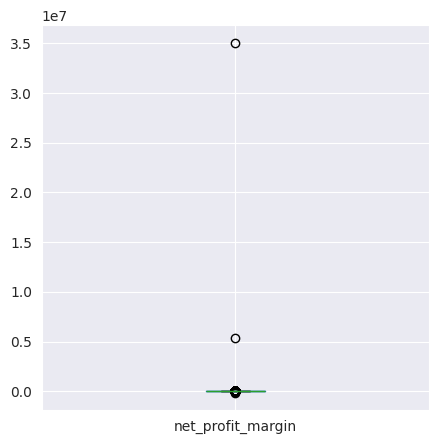

In [30]:
plt.figure(figsize=(5,5))
df_c.boxplot("net_profit_margin")

/home/anabel/repositories/FoDS_Practicals/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


<Axes: >

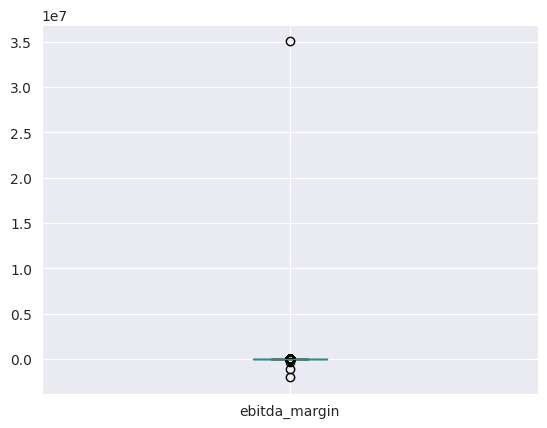

In [31]:
df_c.boxplot("ebitda_margin")

<Axes: >

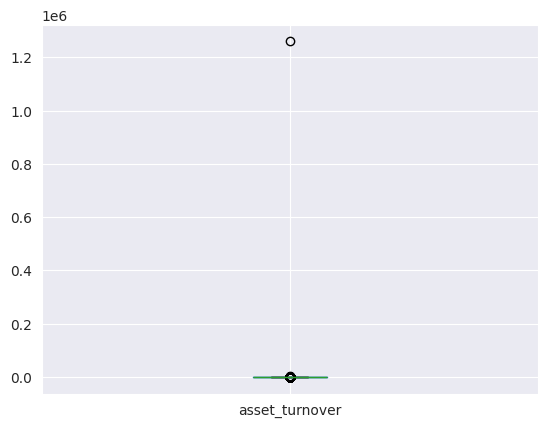

In [32]:
df_c.boxplot("asset_turnover")

In [33]:
def outlier_limits(col):
    Q3, Q1 = np.nanpercentile(col, [75,25])
    IQR = Q3-Q1
    UL = Q3+1.5*IQR
    LL = Q1-1.5*IQR
    return UL,LL    

In [34]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29563 entries, 0 to 29562
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   industry                        29563 non-null  object 
 1   business_description_embedding  29563 non-null  object 
 2   country_code                    29563 non-null  object 
 3   net_profit_margin               28452 non-null  float64
 4   ebitda_margin                   10284 non-null  float64
 5   asset_turnover                  28200 non-null  float64
dtypes: float64(3), object(3)
memory usage: 1.4+ MB


In [35]:
df_c_mod = df_c.copy()

In [36]:
for column in df_c.columns:
    if df_c_mod[column].dtype=="float64":
        UL, LL = outlier_limits(df_c_mod[column])
        df_c_mod[column] = np.where((df_c_mod[column] > UL) | (df_c_mod[column]<LL), np.nan, df_c_mod[column])

In [37]:
df_c_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29563 entries, 0 to 29562
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   industry                        29563 non-null  object 
 1   business_description_embedding  29563 non-null  object 
 2   country_code                    29563 non-null  object 
 3   net_profit_margin               21982 non-null  float64
 4   ebitda_margin                   8040 non-null   float64
 5   asset_turnover                  27001 non-null  float64
dtypes: float64(3), object(3)
memory usage: 1.4+ MB


In [38]:
df_c_mod.isnull().sum()

industry                              0
business_description_embedding        0
country_code                          0
net_profit_margin                  7581
ebitda_margin                     21523
asset_turnover                     2562
dtype: int64

In [39]:
df_c_mod["country_code"].value_counts()

country_code
USA    5074
DEU    4598
CHN    4228
CAN    2191
KOR    1631
       ... 
VNM       1
MAR       1
MOZ       1
BWA       1
LIE       1
Name: count, Length: 98, dtype: int64

In [40]:
from sklearn.impute import KNNImputer

In [41]:
from sklearn.preprocessing import OneHotEncoder

In [42]:
df_c_mod["country_code"].unique()

array(['USA', 'DEU', 'CHN', 'IDN', 'KOR', 'MYS', 'AUS', 'THA', 'POL',
       'TWN', 'CHL', 'SGP', 'CAN', 'HKG', 'IND', 'TUR', 'NOR', 'ZAF',
       'JPN', 'DNK', 'NLD', 'GBR', 'SWE', 'CHE', 'MEX', 'ISR', 'BEL',
       'AUT', 'GRC', 'ARG', 'FRA', 'IMN', 'FIN', 'JEY', 'ESP', 'BMU',
       'MLT', 'NAM', 'BRA', 'PRT', 'VGB', 'ITA', 'PHL', 'CYM', 'IRL',
       'ISL', 'NGA', 'LTU', 'HUN', 'BHS', 'KEN', 'MAC', 'PER', 'KHM',
       'COL', 'CYP', 'URY', 'CRI', 'JOR', 'GGY', 'LUX', 'ARE', 'PAK',
       'NZL', 'SVK', 'MUS', 'EST', 'MCO', 'GUF', 'CZE', 'RUS', 'KAZ',
       'MKD', 'GIB', 'DOM', 'GRL', 'MMR', 'BGR', 'ZMB', 'SVN', 'PAN',
       'PNG', 'BLZ', 'UKR', 'BRB', 'ROU', 'LBR', 'AZE', 'TZA', 'MNE',
       'MNG', 'BGD', 'VNM', 'LVA', 'MAR', 'MOZ', 'BWA', 'LIE'],
      dtype=object)

In [43]:
ohe = OneHotEncoder(sparse_output=False).set_output(transform="pandas")

country_ohe_transformed = ohe.fit_transform(df_c_mod[["country_code"]])

In [44]:
country_ohe_transformed

,country_code_ARE,country_code_ARG,country_code_AUS,country_code_AUT,country_code_AZE,country_code_BEL,country_code_BGD,country_code_BGR,country_code_BHS,country_code_BLZ,...,country_code_TUR,country_code_TWN,country_code_TZA,country_code_UKR,country_code_URY,country_code_USA,country_code_VGB,country_code_VNM,country_code_ZAF,country_code_ZMB
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
country_ohe_transformed_USA_is_0_dummy = country_ohe_transformed.drop(columns=["country_code_USA"])
country_ohe_transformed_USA_is_0_dummy

,country_code_ARE,country_code_ARG,country_code_AUS,country_code_AUT,country_code_AZE,country_code_BEL,country_code_BGD,country_code_BGR,country_code_BHS,country_code_BLZ,...,country_code_THA,country_code_TUR,country_code_TWN,country_code_TZA,country_code_UKR,country_code_URY,country_code_VGB,country_code_VNM,country_code_ZAF,country_code_ZMB
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
df_c2 = pd.concat([df_c_mod, country_ohe_transformed_USA_is_0_dummy], axis=1).drop(columns=["country_code"])
df_c2

industry  \
0                                   Banks   
1                               Materials   
2      Commercial & Professional Services   
3                               Insurance   
4                           Capital Goods   
...                                   ...   
29558                       Capital Goods   
29559                       Capital Goods   
29560                      Transportation   
29561     Technology Hardware & Equipment   
29562                   Consumer Services   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [47]:
df_c2_knn = df_c2.copy().drop(columns=["industry","business_description_embedding"])
df_c2_knn

,net_profit_margin,ebitda_margin,asset_turnover,country_code_ARE,country_code_ARG,country_code_AUS,country_code_AUT,country_code_AZE,country_code_BEL,country_code_BGD,...,country_code_THA,country_code_TUR,country_code_TWN,country_code_TZA,country_code_UKR,country_code_URY,country_code_VGB,country_code_VNM,country_code_ZAF,country_code_ZMB
0,0.155503,NaN,0.033292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.023660,NaN,0.861915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001364,NaN,1.348739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.022178,NaN,0.461366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.071349,NaN,0.555100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29558,0.032470,NaN,0.465017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29559,0.070754,NaN,0.427210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29560,0.057209,NaN,0.811376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29561,0.030016,NaN,0.577162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
knnimputer = KNNImputer()

In [49]:
df_c2_knn.isnull().sum()

net_profit_margin     7581
ebitda_margin        21523
asset_turnover        2562
country_code_ARE         0
country_code_ARG         0
                     ...  
country_code_URY         0
country_code_VGB         0
country_code_VNM         0
country_code_ZAF         0
country_code_ZMB         0
Length: 100, dtype: int64

In [50]:
df_c2_knn.iloc[:,:]=knnimputer.fit_transform(df_c2_knn)

In [51]:
df_c2_knn.isnull().sum()

net_profit_margin    0
ebitda_margin        0
asset_turnover       0
country_code_ARE     0
country_code_ARG     0
                    ..
country_code_URY     0
country_code_VGB     0
country_code_VNM     0
country_code_ZAF     0
country_code_ZMB     0
Length: 100, dtype: int64

In [52]:
df_c2_i_b = df_c2.loc[:, ["industry", "business_description_embedding"]].copy()

In [53]:
df_c2_i_b

industry  \
0                                   Banks   
1                               Materials   
2      Commercial & Professional Services   
3                               Insurance   
4                           Capital Goods   
...                                   ...   
29558                       Capital Goods   
29559                       Capital Goods   
29560                      Transportation   
29561     Technology Hardware & Equipment   
29562                   Consumer Services   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [54]:
df_c_witoutoutliersormissingvalues = pd.concat([df_c2_i_b, df_c2_knn], axis=1)
df_c_witoutoutliersormissingvalues

industry  \
0                                   Banks   
1                               Materials   
2      Commercial & Professional Services   
3                               Insurance   
4                           Capital Goods   
...                                   ...   
29558                       Capital Goods   
29559                       Capital Goods   
29560                      Transportation   
29561     Technology Hardware & Equipment   
29562                   Consumer Services   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [55]:
df_c_witoutoutliersormissingvalues.isnull().sum()

industry                          0
business_description_embedding    0
net_profit_margin                 0
ebitda_margin                     0
asset_turnover                    0
                                 ..
country_code_URY                  0
country_code_VGB                  0
country_code_VNM                  0
country_code_ZAF                  0
country_code_ZMB                  0
Length: 102, dtype: int64

In [56]:
df_c_witoutoutliersormissingvalues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29563 entries, 0 to 29562
Columns: 102 entries, industry to country_code_ZMB
dtypes: float64(100), object(2)
memory usage: 23.0+ MB


In [57]:
dff = df_c_witoutoutliersormissingvalues.copy()

<Axes: ylabel='net_profit_margin'>

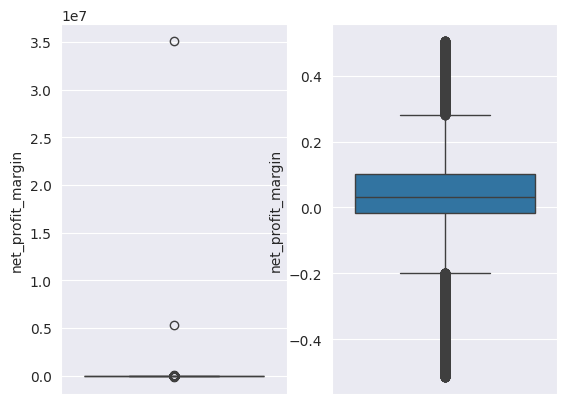

In [58]:
#todo: modify axises
plt.subplot(1,2,1)
sns.boxplot(y=df_c.net_profit_margin)

plt.subplot(1,2,2)
sns.boxplot(y=dff.net_profit_margin)

<Axes: ylabel='ebitda_margin'>

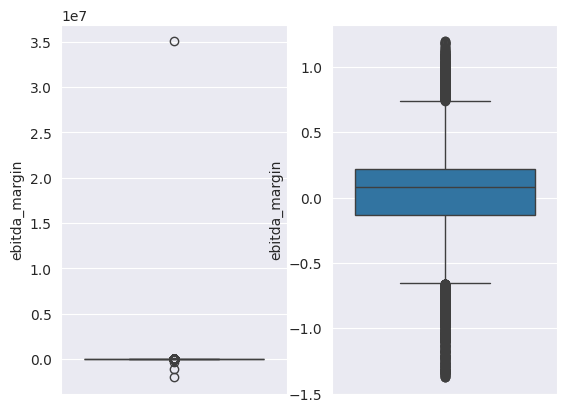

In [59]:
plt.subplot(1,2,1)
sns.boxplot(y=df_c.ebitda_margin)

plt.subplot(1,2,2)
sns.boxplot(y=dff.ebitda_margin)

<Axes: ylabel='asset_turnover'>

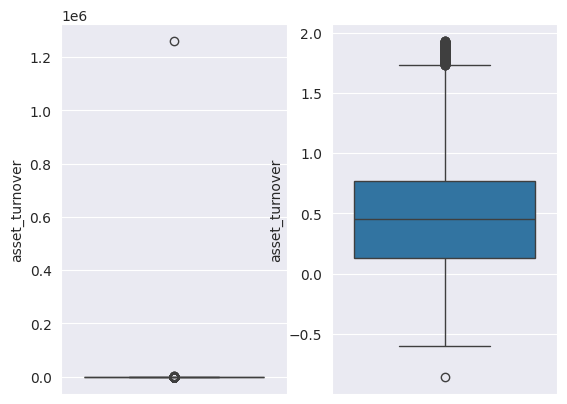

In [60]:
plt.subplot(1,2,1)
sns.boxplot(y=df_c.asset_turnover)

plt.subplot(1,2,2)
sns.boxplot(y=dff.asset_turnover)

In [61]:
dff_train, dff_val = train_test_split(dff, test_size= 0.2, random_state=83)

In [62]:
X_f_embed_train = dff_train.business_description_embedding.apply(ast.literal_eval).tolist()
X_f_embed_train = np.array(X_f_embed_train)

In [63]:
X_f_embed_train

array([[-0.02555741,  0.0636078 , -0.01350581, ..., -0.00419293,
        -0.04597831,  0.01839585],
       [-0.02661143, -0.0386407 , -0.00795991, ..., -0.03866627,
        -0.08107554, -0.02045046],
       [-0.02555741,  0.0636078 , -0.01350581, ..., -0.00419293,
        -0.04597831,  0.01839585],
       ...,
       [ 0.00049932, -0.01379203, -0.03163735, ..., -0.02363429,
        -0.08382864, -0.01551917],
       [ 0.04689967, -0.00131596, -0.06217883, ..., -0.01250981,
        -0.00383119,  0.00237739],
       [-0.02555741,  0.0636078 , -0.01350581, ..., -0.00419293,
        -0.04597831,  0.01839585]], shape=(23650, 768))

In [64]:
X_f_embed_val = dff_val.business_description_embedding.apply(ast.literal_eval).tolist()
X_f_embed_val = np.array(X_f_embed_val)

In [65]:
X_f_embed_val

array([[ 0.05304201,  0.03982058, -0.01331699, ..., -0.00125311,
        -0.02852082, -0.02880038],
       [ 0.05212997, -0.06743749, -0.02447897, ..., -0.02045668,
        -0.04113109, -0.0492478 ],
       [ 0.02083757,  0.01840139, -0.02192268, ...,  0.02697018,
        -0.05779619,  0.00384437],
       ...,
       [ 0.03712859, -0.02101087,  0.01074535, ..., -0.04511841,
        -0.0990735 , -0.00264198],
       [ 0.01734344, -0.02538687, -0.01180954, ..., -0.00364164,
        -0.02895222, -0.03116197],
       [ 0.01744579, -0.01019094,  0.02899619, ..., -0.00583243,
        -0.04554824, -0.00811349]], shape=(5913, 768))

In [66]:
float_cols = dff.select_dtypes(include=["float64"]).columns.tolist()
print(float_cols)

['net_profit_margin', 'ebitda_margin', 'asset_turnover', 'country_code_ARE', 'country_code_ARG', 'country_code_AUS', 'country_code_AUT', 'country_code_AZE', 'country_code_BEL', 'country_code_BGD', 'country_code_BGR', 'country_code_BHS', 'country_code_BLZ', 'country_code_BMU', 'country_code_BRA', 'country_code_BRB', 'country_code_BWA', 'country_code_CAN', 'country_code_CHE', 'country_code_CHL', 'country_code_CHN', 'country_code_COL', 'country_code_CRI', 'country_code_CYM', 'country_code_CYP', 'country_code_CZE', 'country_code_DEU', 'country_code_DNK', 'country_code_DOM', 'country_code_ESP', 'country_code_EST', 'country_code_FIN', 'country_code_FRA', 'country_code_GBR', 'country_code_GGY', 'country_code_GIB', 'country_code_GRC', 'country_code_GRL', 'country_code_GUF', 'country_code_HKG', 'country_code_HUN', 'country_code_IDN', 'country_code_IMN', 'country_code_IND', 'country_code_IRL', 'country_code_ISL', 'country_code_ISR', 'country_code_ITA', 'country_code_JEY', 'country_code_JOR', 'co

In [67]:
X_f_float_train = dff_train[float_cols].to_numpy()

In [68]:
X_f_float_train

array([[ 0.07572705, -0.14388615,  1.02830882, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.05040303,  0.26673908,  1.41008504, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.11791237, -0.11514189,  0.32606251, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.01876049,  0.05568831,  0.77026604, ...,  0.        ,
         0.        ,  0.        ],
       [-0.1844296 , -0.29195952,  0.12306653, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0209389 , -0.2895938 ,  0.82026686, ...,  0.        ,
         0.        ,  0.        ]], shape=(23650, 100))

In [69]:
X_f_float_val = dff_val[float_cols].to_numpy()

In [70]:
X_f_float_val

array([[ 0.07904483,  0.11108702,  0.94061016, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.21659041,  0.41628366,  0.40190676, ...,  0.        ,
         0.        ,  0.        ],
       [-0.14679847, -0.11013219,  0.72419297, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.02773819,  0.3077848 ,  0.47985331, ...,  0.        ,
         0.        ,  0.        ],
       [-0.28319943, -0.1105874 ,  1.34097874, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.06956826,  0.27425554,  0.49395877, ...,  0.        ,
         0.        ,  0.        ]], shape=(5913, 100))

In [71]:
X_f_train=np.hstack([X_f_embed_train,X_f_float_train])
X_f_val=np.hstack([X_f_embed_val,X_f_float_val])

In [72]:
X_f_train

array([[-0.02555741,  0.0636078 , -0.01350581, ...,  0.        ,
         0.        ,  0.        ],
       [-0.02661143, -0.0386407 , -0.00795991, ...,  0.        ,
         0.        ,  0.        ],
       [-0.02555741,  0.0636078 , -0.01350581, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.00049932, -0.01379203, -0.03163735, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04689967, -0.00131596, -0.06217883, ...,  0.        ,
         0.        ,  0.        ],
       [-0.02555741,  0.0636078 , -0.01350581, ...,  0.        ,
         0.        ,  0.        ]], shape=(23650, 868))

In [73]:
X_f_val

array([[ 0.05304201,  0.03982058, -0.01331699, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.05212997, -0.06743749, -0.02447897, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02083757,  0.01840139, -0.02192268, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.03712859, -0.02101087,  0.01074535, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01734344, -0.02538687, -0.01180954, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01744579, -0.01019094,  0.02899619, ...,  0.        ,
         0.        ,  0.        ]], shape=(5913, 868))

In [74]:
label_encoder_c = LabelEncoder().fit(y=dff["industry"].values.ravel())
print(label_encoder_c.classes_)

['Automobiles & Components' 'Banks' 'Capital Goods'
 'Commercial & Professional Services'
 'Consumer Discretionary Distribution & Retail'
 'Consumer Durables & Apparel' 'Consumer Services'
 'Consumer Staples Distribution & Retail' 'Energy'
 'Equity Real Estate Investment Trusts (REITs)' 'Financial Services'
 'Food, Beverage & Tobacco' 'Health Care Equipment & Services'
 'Household & Personal Products' 'Insurance' 'Materials'
 'Media & Entertainment' 'Pharmaceuticals, Biotechnology & Life Sciences'
 'Real Estate Management & Development'
 'Semiconductors & Semiconductor Equipment' 'Software & Services'
 'Technology Hardware & Equipment' 'Telecommunication Services'
 'Transportation' 'Utilities']


In [75]:
y_f_train = label_encoder.transform(dff_train['industry'])
y_f_val = label_encoder.transform(dff_val['industry']) 

### Develop an ensemble system incl Combination of classification models (e.g. kNN + Logistic Regression)
When figuring out what an ensemle system is, I discovered that: "Ensemble learning typically refers to bagging (bootstrap aggregating), boosting or stacking/blending techniques to induce high variance among the base models." (Wikipedia)
I thought that stacking would fit the exercise description the best and found the following explanation video where I drew some insparation form:
- https://www.youtube.com/watch?v=0BGLfYY26zQ

In [76]:
knn_f = KNeighborsClassifier(n_neighbors=15, weights='distance', metric='cosine')
knn_f.fit(X_f_train, y_f_train)

,n_neighbors,15
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'cosine'
,metric_params,None
,n_jobs,None


In [77]:
y_pred_knn_f = knn_f.predict(X_f_val)
knn_accuracy_f = accuracy_score(y_f_val, y_pred_knn_f)
knn_f1_f = f1_score(y_f_val, y_pred_knn_f, average='weighted')
print(f"\nk-Nearest Neighbors:")
print(f"  Accuracy: {knn_accuracy_f:.4f}")
print(f"  F1-score: {knn_f1_f:.4f}")


k-Nearest Neighbors:
  Accuracy: 0.6902
  F1-score: 0.6841


In [78]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_f_train, y_f_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [79]:
y_pred_dt_f = dt.predict(X_f_val)
dt_accuracy_f = accuracy_score(y_f_val, y_pred_dt_f)
dt_f1_f = f1_score(y_f_val, y_pred_dt_f, average='weighted')
print(f"\DecisionTreeClassifier:")
print(f"  Accuracy: {dt_accuracy_f:.4f}")
print(f"  F1-score: {dt_f1_f:.4f}")

\DecisionTreeClassifier:
  Accuracy: 0.5550
  F1-score: 0.5551


In [80]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_f_train, y_f_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [81]:
y_pred_rf_f = rf.predict(X_f_val)
rf_accuracy_f = accuracy_score(y_f_val, y_pred_rf_f)
rf_f1_f = f1_score(y_f_val, y_pred_rf_f, average='weighted')
print(f"\RandomForestClassifier:")
print(f"  Accuracy: {rf_accuracy_f:.4f}")
print(f"  F1-score: {rf_f1_f:.4f}")

\RandomForestClassifier:
  Accuracy: 0.7599
  F1-score: 0.7482


In [105]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=100, random_state=42)
mlp.fit(X_f_train, y_f_train)

/home/anabel/repositories/FoDS_Practicals/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


,hidden_layer_sizes,"(100,)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,100
,shuffle,True
,random_state,42


In [106]:
y_pred_mlp_f = mlp.predict(X_f_val)
mlp_accuracy_f = accuracy_score(y_f_val, y_pred_mlp_f)
mlp_f1_f = f1_score(y_f_val, y_pred_mlp_f, average='weighted')
print(f"\MLPClassifier:")
print(f"  Accuracy: {mlp_accuracy_f:.4f}")
print(f"  F1-score: {mlp_f1_f:.4f}")

\MLPClassifier:
  Accuracy: 0.7752
  F1-score: 0.7736


In [103]:
log_reg_f = LogisticRegression(random_state=42, solver='newton-cg')
log_reg_f.fit(X_f_train, y_f_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'newton-cg'
,max_iter,100
,multi_class,'deprecated'


In [85]:
y_pred_log_reg_f = log_reg_f.predict(X_f_val)
log_reg_accuracy_f = accuracy_score(y_f_val, y_pred_log_reg_f)
log_reg_f1_f = f1_score(y_f_val, y_pred_log_reg_f, average='weighted')
print(f"\RandomForestClassifier:")
print(f"  Accuracy: {log_reg_accuracy_f:.4f}")
print(f"  F1-score: {log_reg_f1_f:.4f}")

\RandomForestClassifier:
  Accuracy: 0.7839
  F1-score: 0.7788


In [114]:
from sklearn.ensemble import StackingClassifier
estimator_list = [('log_reg_f',log_reg_f),("knn_f",knn_f), ("dt", dt), ("rf", rf), ("mlp",mlp)]

In [115]:
stack_model = StackingClassifier(estimators=estimator_list, final_estimator=LogisticRegression())

In [116]:
stack_model.fit(X_f_train, y_f_train)

/home/anabel/repositories/FoDS_Practicals/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/anabel/repositories/FoDS_Practicals/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/anabel/repositories/FoDS_Practicals/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/anabel/repositories/FoDS_Practicals/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reac

,estimators,"[('log_reg_f', ...), ('knn_f', ...), ...]"
,final_estimator,LogisticRegression()
,cv,None
,stack_method,'auto'
,n_jobs,None
,passthrough,False
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [119]:
y_pred_stack_model_f = stack_model.predict(X_f_val)
stack_model_accuracy_f = accuracy_score(y_f_val, y_pred_stack_model_f)
stack_model_f1_f = f1_score(y_f_val, y_pred_stack_model_f, average='weighted')
print(f"\StackingClassifier:")
print(f"  Accuracy: {stack_model_accuracy_f:.4f}")
print(f"  F1-score: {stack_model_f1_f:.4f}")

\StackingClassifier:
  Accuracy: 0.7913
  F1-score: 0.7891


### Statistical analysis of financial distributions across industries (Note that we provide financial performance figures that make sense.)
#TODO

### Create uncertainty quantification framework
- https://www.youtube.com/watch?v=yJK4sYclhg8
- https://www.youtube.com/watch?v=zm3MIJmYIZI
- https://stackoverflow.com/questions/29217399/convert-list-of-numpy-float64-to-float-in-python-quickly

#TODO's
- Flag uncertain classifications for potential human review
- analyze the relationship between statistical confidence and classification accuracy

In [147]:
prediction_small = stack_model.predict_proba(X_f_val[:5])
prediction_small

array([[6.42190991e-04, 3.74328061e-04, 1.31642247e-02, 3.21957155e-03,
        4.94635964e-03, 3.17852292e-03, 1.17728622e-02, 3.43996852e-02,
        1.75631999e-02, 7.22638783e-04, 1.17452020e-02, 4.32070061e-01,
        1.42687120e-02, 2.09547499e-02, 4.08284160e-04, 9.68581671e-02,
        1.30881360e-03, 3.17964785e-01, 4.49835123e-03, 9.96382403e-04,
        2.39448040e-03, 3.18729458e-03, 4.70455705e-04, 6.92555941e-04,
        2.19812130e-03],
       [2.10775434e-04, 1.36126567e-03, 2.36020438e-03, 4.43128980e-03,
        6.06190529e-03, 5.93027277e-03, 1.61118344e-01, 1.14012836e-03,
        5.66615880e-03, 2.53220338e-03, 4.91111884e-03, 6.64785950e-04,
        1.57551194e-03, 1.40754362e-03, 9.57674077e-04, 5.09230785e-03,
        7.52180445e-01, 2.52593528e-04, 4.06417733e-03, 3.41107628e-04,
        2.93104177e-02, 3.02892512e-03, 4.11702720e-03, 8.58962599e-04,
        4.24853733e-04],
       [2.08336138e-04, 5.32612929e-06, 1.23541993e-03, 5.20295365e-04,
        4.0428

In [148]:
stack_model.predict(X_f_val[:5])

array([11, 16, 15, 11, 15])

In [149]:
confidence_list_small = []
for line in prediction_small:
    confidence_list_small.append(max(line).tolist())

confidence_list_small

[0.43207006108499496,
 0.7521804454297729,
 0.9916406737539818,
 0.7161329403033228,
 0.9369556846917317]

In [150]:
confidence_small = np.array(confidence_list_small, dtype='float64')
confidence_small

array([0.43207006, 0.75218045, 0.99164067, 0.71613294, 0.93695568])

In [151]:
prediction = stack_model.predict_proba(X_f_val)
prediction

array([[6.42190991e-04, 3.74328061e-04, 1.31642247e-02, ...,
        4.70455705e-04, 6.92555941e-04, 2.19812130e-03],
       [2.10775434e-04, 1.36126567e-03, 2.36020438e-03, ...,
        4.11702720e-03, 8.58962599e-04, 4.24853733e-04],
       [2.08336138e-04, 5.32612929e-06, 1.23541993e-03, ...,
        8.83141125e-06, 2.88056718e-05, 3.92546984e-05],
       ...,
       [1.38765035e-03, 6.17650916e-05, 2.06778059e-02, ...,
        1.13137755e-04, 3.94897471e-04, 4.80542185e-04],
       [2.22553383e-02, 2.92405220e-04, 6.61913953e-01, ...,
        5.32787573e-04, 7.40178078e-03, 4.50202260e-03],
       [2.63568515e-03, 1.03667242e-03, 1.67578493e-02, ...,
        7.40630193e-04, 2.32583779e-02, 3.46824285e-02]], shape=(5913, 25))

In [152]:
confidence_list = []
for line in prediction:
    confidence_list.append(max(line).tolist())

confidence_list

[0.43207006108499546,
 0.7521804454297726,
 0.9916406737539818,
 0.7161329403033226,
 0.9369556846917315,
 0.9904427959296818,
 0.2056880022045387,
 0.9812671057065452,
 0.9937426873020695,
 0.7974002910841917,
 0.9723466314840373,
 0.4709675047520574,
 0.6159703418266672,
 0.9938440382122139,
 0.31724014104847653,
 0.8974702520112811,
 0.5743845921325677,
 0.9754824789945067,
 0.9953771379922023,
 0.9814504762324345,
 0.869951023095168,
 0.8817965589461699,
 0.9071223576514016,
 0.9349309417096674,
 0.9938172714327522,
 0.8582427930808931,
 0.9493509614549414,
 0.9348597665874874,
 0.9938368213714486,
 0.5012161744762836,
 0.8332226262240454,
 0.848519539511825,
 0.8825895909292062,
 0.38007639633346546,
 0.2527896846997588,
 0.7851846033968314,
 0.9611172700854848,
 0.8312613550070931,
 0.99383430283128,
 0.9563679761443084,
 0.9938361550867654,
 0.9749843856919207,
 0.6811087794766181,
 0.9782986958067679,
 0.9432469078889423,
 0.9675213388268896,
 0.9694140575351963,
 0.95164477971

In [153]:
confidence = np.array(confidence_list, dtype='float64')
confidence

array([0.43207006, 0.75218045, 0.99164067, ..., 0.93168493, 0.66191395,
       0.71827012], shape=(5913,))

### Improve the confidence-weighted F1 score to above 85% (measured on private test dataset; definition of confidence-weighted F1 score provided in notebook)

In [155]:
f1_weighted = confidence_weighted_f1(y_f_val, y_pred_stack_model_f, confidence)

In [165]:
print(f"\StackingClassifier:")
print(f"  True labels:___________________{y_f_val}")
print(f"  Predicted labels:______________{y_pred_stack_model_f}")
print(f"  Confidence:____________________{confidence}")
print(f"  Accuracy:______________________{stack_model_accuracy_f:.4f}")
print(f"  Standard F1-score:_____________{stack_model_f1_f:.4f}")
print(f"  Confidence-weighted F1 score:__{f1_weighted:.4f}")

\StackingClassifier:
  True labels:___________________[11 16 15 ... 15  2  8]
  Predicted labels:______________[11 16 15 ... 15  2  8]
  Confidence:____________________[0.43207006 0.75218045 0.99164067 ... 0.93168493 0.66191395 0.71827012]
  Accuracy:______________________0.7913
  Standard F1-score:_____________0.7891
  Confidence-weighted F1 score:__1.0000
